In [1]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
MyDrive  Shareddrives


In [2]:
import os

BASE_PATH = '/gdrive/My Drive/Classes/CSE 455/ghabt/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

os.chdir(BASE_PATH)
!pwd
!ls
DATA_PATH = BASE_PATH + 'cifar/'

/gdrive/My Drive/Classes/CSE 455/ghabt
cifar					 test_perturbed_6_CifarNet1.png
cifar.test				 test_perturbed_6_CifarNet2.png
cifar.tgz				 test_perturbed_6_CifarNet4.png
cifar.train				 test_perturbed_7_CifarNet1.png
load_cifar.sh				 test_perturbed_7_CifarNet2.png
perturbation_tensors_test_CifarNet1.pt	 test_perturbed_7_CifarNet4.png
perturbation_tensors_test_CifarNet2.pt	 test_perturbed_8_CifarNet1.png
perturbation_tensors_test_CifarNet4.pt	 test_perturbed_8_CifarNet2.png
perturbation_tensors_test_test.pt	 test_perturbed_8_CifarNet4.png
perturbation_tensors_train_CifarNet1.pt  test_perturbed_9_CifarNet1.png
perturbation_tensors_train_CifarNet2.pt  test_perturbed_9_CifarNet2.png
perturbation_tensors_train_CifarNet4.pt  test_perturbed_9_CifarNet4.png
perturbation_tensors_train_train.pt	 train_original_0.png
pt_util.py				 train_original_1.png
__pycache__				 train_original_2.png
test0.png				 train_original_3.png
test1.png				 train_original_4.png
test2.png				 train_original_5.png
t

In [45]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [44]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

In [7]:
data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def trainAndSaveModel(modelClass):
    # Play around with these constants, you may find a better setting.
    BATCH_SIZE = 256
    TEST_BATCH_SIZE = 10
    EPOCHS = 50
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9
    USE_CUDA = True
    SEED = None
    PRINT_INTERVAL = 250
    WEIGHT_DECAY = 0.0005

    EXPERIMENT_VERSION = f'{modelClass.__name__}_1' # increment this to start a new experiment
    LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

    # Now the actual training code
    use_cuda = USE_CUDA and torch.cuda.is_available()

    if SEED is not None:
      torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    print('num cpus:', multiprocessing.cpu_count())

    kwargs = {'num_workers': multiprocessing.cpu_count(),
              'pin_memory': True} if use_cuda else {}

    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                              shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = modelClass().to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

# Network 1

In [4]:
# Test set: TODO record avg loss, accuracy for this one
class CifarNet1(nn.Module):
    def __init__(self):
        super(CifarNet1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=16384, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#trainAndSaveModel(CifarNet1)

# Network 2

In [5]:
# Test set: TODO record avg loss, accuracy for this one
class CifarNet2(nn.Module):
    def __init__(self):
        super(CifarNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=16384, out_features=10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#trainAndSaveModel(CifarNet2)

# Network 4

In [6]:
# Test set: TODO record avg loss, accuracy for this one
class CifarNet4(nn.Module):
    def __init__(self):
        super(CifarNet4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=16384, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#trainAndSaveModel(CifarNet4)

# Network 5

In [7]:
# Test set: TODO record avg loss, accuracy for this one
class CifarNet5(nn.Module):
    def __init__(self):
        super(CifarNet5, self).__init__()
        self.mp = nn.MaxPool2d(3, stride=2, padding=1)
        self.dropout = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 1024, 3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, 3, stride=2, padding=1)
        self.conv8_bn = nn.BatchNorm2d(2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,200)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = self.dropout(x)
        X = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.conv6_bn(x)
        x= F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = self.conv8_bn(x)
        x = self.mp(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#trainAndSaveModel(CifarNet5)

# Network 6

In [8]:
# Test set: TODO record avg loss, accuracy for this one
class CifarNet6(nn.Module):
    def __init__(self):
        super(CifarNet6, self).__init__()
        self.dropout = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 1024, 3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, 3, stride=2, padding=1)
        self.conv8_bn = nn.BatchNorm2d(2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = self.dropout(x)
        X = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.conv6_bn(x)
        x= F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = self.conv8_bn(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#trainAndSaveModel(CifarNet6)

# Perturbations
Note: Assumes all models use standard cross entropy for their loss. If not, should go back and add a version of loss to each class that doesn't squeeze the label parameter then change the corresponding calls below to call model.loss()

In [ ]:
# Make sure data is unaugmented
from torchvision.utils import save_image
#print(data_train)
#print(str(type(data_train)))
#print(dir(data_train))
print(data_train[0])
for x in range(10):
  save_image((data_train[x])[0], 'test' + str(x) + '.png')

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

In [132]:
def ce_loss(prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label, reduction=reduction)
        return loss_val

# original version
# perturbations is a list of zerod tensors (basically like zerod data_train / whatever)
def pertube_images(model, data, labels, pertubations, eps, lr, epochs):
    accuracies = list()
    criterion = nn.NLLLoss()
    for epoch in range(10):
        tot = 0
        corr = 0
        for i in range(len(data)):
            model.zero_grad()
            tot += 1
            output = model(torch.unsqueeze(data[i][0] + pertubations[i], 0))
            if torch.argmax(output).item() == data[i][1]:
                corr += 1
            loss = ce_loss(output, torch.LongTensor([data[i][1]]))
            loss.backward()
            pertubations[i] = torch.clamp(pertubations[i].grad * lr + pertubations[i], -eps, eps).detach().clone()
            pertubations[i].requires_grad = True
        accuracies.append(corr / tot)
    return accuracies

#TODO: momentum?
def perturb_images(model, data, perturbations, eps, lr, epochs):
    accuracies = list()
    criterion = nn.NLLLoss()
    for epoch in range(10):
        tot = 0
        corr = 0
        for i in range(len(data)):
            if i % 100 == 0:
              print(i, end=' ')
            model.zero_grad()
            if perturbations[i].grad: # initially will be set to None
              perturbations[i].grad.zero_()
            tot += 1
            output = model(torch.unsqueeze(data[i][0] + perturbations[i], 0))
            if torch.argmax(output).item() == data[i][1]:
                corr += 1
            loss = ce_loss(output, torch.LongTensor([data[i][1]]))
            loss.backward()
            perturbations[i] = torch.clamp(perturbations[i].grad * lr + perturbations[i], -eps, eps).detach().clone()
        print()
        print('epoch ' + str(epoch) + ' finished: ' + str(corr) + '/' + str(tot))
        accuracies.append(corr / tot)
    return accuracies

def perturb_model_dataset(model, dataset, eps, lr, epochs, num_examples, prefix, *argv):
  p_list = [torch.zeros(*argv) for x in range(len(dataset))]
  for p in p_list:
    p.requires_grad = True
  accuracies = perturb_images(model, dataset, p_list, eps, lr, epochs)
  print(prefix + " set perturbation training accuracies (by epoch): " + str(accuracies))
  for i in range(num_examples):
    save_image(dataset[i][0], prefix + '_original_' + str(i) + '.png')
    save_image(dataset[i][0] + p_list[i], prefix + '_perturbed_' + str(i) + '_' + model_name + '.png')
  torch.save(p_list, 'perturbation_tensors_' + prefix + '_' + model_name + '.pt')

def perturb_cifar_model(model, train_data, test_data, eps=0.01, lr=0.0001, epochs=10, num_examples=10):
  model_name = type(model).__name__
  perturb_model_dataset(model, train_data, eps, lr, epochs, num_examples, 'train', 3, 32, 32)
  perturb_model_dataset(model, test_data, eps, lr, epochs, num_examples, 'test', 3, 32, 32)
    
def perturb_cifar_class(modelClass, train_data, test_data):
  EXPERIMENT_VERSION = f'{modelClass.__name__}_1' # change this to appropriate experiment
  LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
  model = modelClass()
  epoch = model.load_last_model(LOG_PATH)
  if epoch < 1:
    print('WARNING: MODEL MAY NOT HAVE BEEN LOADED')
  print(str(type(model)))
  perturb_cifar_model(model, train_data, test_data)



In [27]:
from torchvision.utils import save_image

def ce_loss(prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label, reduction=reduction)
        return loss_val

# NOT SUPPORTED ANYMORE WITH DATALOADER
# original version
# perturbations is a list of zerod tensors (basically like zerod data_train / whatever)
def pertube_images(model, data, labels, pertubations, eps, lr, epochs):
    accuracies = list()
    criterion = nn.NLLLoss()
    for epoch in range(10):
        tot = 0
        corr = 0
        for i in range(len(data)):
            model.zero_grad()
            tot += 1
            output = model(torch.unsqueeze(data[i][0] + pertubations[i], 0))
            if torch.argmax(output).item() == data[i][1]:
                corr += 1
            loss = ce_loss(output, torch.LongTensor([data[i][1]]))
            loss.backward()
            pertubations[i] = torch.clamp(pertubations[i].grad * lr + pertubations[i], -eps, eps).detach().clone()
            pertubations[i].requires_grad = True
        accuracies.append(corr / tot)
    return accuracies

#TODO: momentum?
def perturb_images(device, model, dataloader, perturbations, eps, lr, epochs):
    accuracies = list()
    for epoch in range(10):
        tot = 0
        corr = 0
        for batch_idx, (data, label) in enumerate(dataloader):
            data, label = data.to(device), label.to(device)
            if batch_idx % 100 == 0:
              print(batch_idx * data.size(0), end=' ')
            model.zero_grad()
            if perturbations[batch_idx].grad != None: # initially will be set to None
              perturbations[batch_idx].grad.zero_()
            tot += data.size(0)
            output = model(data + perturbations[batch_idx])
            pred = output.max(1)[1]
            #if batch_idx % 100 == 0:
            #  print(perturbations[batch_idx][0])
            #  print('heehoo')
            #  print(output)
            #  print(pred)
            #  print(label)
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            corr += num_correct
            loss = model.loss(output, label, reduction='sum')
            loss.backward()
            if perturbations[batch_idx].grad != None:
              perturbations[batch_idx] = torch.clamp(perturbations[batch_idx].grad * lr + perturbations[batch_idx], -eps, eps).detach().clone()
        print()
        print('epoch ' + str(epoch) + ' finished: ' + str(corr) + '/' + str(tot))
        accuracies.append(corr / tot)
    return accuracies

# argv is dimensions of tensors
def perturb_model_dataset(device, model, dataloader, eps, lr, epochs, num_examples, prefix, *argv):
  model_name = type(model).__name__
  p_list = [torch.zeros(*argv, device=device) for x in range(len(dataloader.dataset) // argv[0])]
  for p in p_list:
    p.requires_grad = True
  accuracies = perturb_images(device, model, dataloader, p_list, eps, lr, epochs)
  print(prefix + " set perturbation training accuracies (by epoch): " + str(accuracies))
  for i in range(num_examples):
    og = dataloader.dataset[i][0]
    p = p_list[i//argv[0]][i%argv[0]].to('cpu')
    save_image(og, prefix + '_original_' + str(i) + '.png')
    save_image(og + p, prefix + '_perturbed_' + str(i) + '_' + model_name + '.png')
  torch.save(p_list, 'perturbation_tensors_' + prefix + '_' + model_name + '.pt')

def perturb_cifar_model(device, model, train_data, test_data, batch_size, eps=0.01, lr=1.0, epochs=10, num_examples=10):
  perturb_model_dataset(device, model, train_data, eps, lr, epochs, num_examples, 'train', batch_size, 3, 32, 32)
  perturb_model_dataset(device, model, test_data, eps, lr, epochs, num_examples, 'test', batch_size, 3, 32, 32)
    
def perturb_cifar_class(modelClass, train_data, test_data):
  USE_CUDA = True
  BATCH_SIZE = 100 # jank means this MUST divide len(train_data) and len(test_data)
  EXPERIMENT_VERSION = f'{modelClass.__name__}_1' # change this to appropriate experiment
  LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
  use_cuda = USE_CUDA and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print('Using device', device)
  import multiprocessing
  print('num cpus:', multiprocessing.cpu_count())

  kwargs = {'num_workers': multiprocessing.cpu_count(),
            'pin_memory': True} if use_cuda else {}

  train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                            shuffle=False, **kwargs)
  test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_SIZE,
                                            shuffle=False, **kwargs)
  model = modelClass().to(device)
  epoch = model.load_last_model(LOG_PATH)
  if epoch < 1:
    print('WARNING: MODEL MAY NOT HAVE BEEN LOADED')
  print(str(type(model)))
  perturb_cifar_model(device, model, train_loader, test_loader, BATCH_SIZE)



In [36]:
from torchvision.utils import save_image
from PIL import Image
from torchvision import transforms

tensorize = transforms.ToTensor()
imagize = transforms.ToPILImage()

def perturb_images(model, examples, labels, name, prefix='ee', num_examples='10'):
  BATCH_SIZE = 100
  lr = 10.
  eps = 0.01
  model_name = type(model).__name__
  criterion = nn.NLLLoss()
  perturbations = [torch.zeros(BATCH_SIZE, 3, 32, 32).to(device).requires_grad_() for im in range(len(labels))]
  for epoch in range(3):
      tot = 0
      corr = 0
      for i in range(len(examples)):
          if i % 10 == 0:
            print(i, end=' ')
          model.zero_grad()
          tot += BATCH_SIZE
          outputs = model(examples[i] + perturbations[i])
          for output, label in zip(outputs, labels[i]):
              if torch.argmax(output).item() == label.item():
                  corr += 1
          loss = criterion(outputs, labels[i])
          loss.backward()
          perturbations[i] = torch.clamp(perturbations[i].grad * lr + perturbations[i], -eps, eps).detach().clone()
          perturbations[i].requires_grad = True
      print()
      print(corr)
      print(tot)
      print(corr / tot)
  #names = [img_name.rstrip().replace('train', 'train_pertubed_02').replace('test', 'test_pertubed_02') for img_name in open('cifar.test', 'r')]
  #idx = 0
  #for example, pertubation in zip(examples, pertubations):
      #for ex, pert in zip(example, pertubation):
          #imagize(ex.cpu() + pert.cpu()).save(names[idx], format='PNG')
          #idx += 1
  torch.save(perturbations, prefix + '_' + model_name + '_' + name + '_perturbations.pt')
  counter = 0
  for i in range(len(examples)):
    model.zero_grad()
    outputs_og = model(examples[i])
    outputs = model(examples[i] + perturbations[i])
    for example, perturbation, output, output_og, label in zip(examples[i], perturbations[i], outputs, outputs_og, labels[i]):
      if (torch.argmax(output).item() != label.item()) and (torch.argmax(output_og).item() == label.item()):
        counter += 1
        print(counter)
        excpu = example.cpu()
        save_image(excpu, prefix + '_' + name + '_' + str(i) + '.png')
        save_image(excpu + perturbation.cpu(), prefix + '_' + name + '_' + str(i) + '_perturbed_' + model_name + '.png')
        if counter == num_examples:
          break
    if counter == num_examples:
      break

def generate_model_perturbations(modelClass):
  USE_CUDA = True
  BATCH_SIZE = 100 # jank means this MUST divide len(train_data) and len(test_data)
  EXPERIMENT_VERSION = f'{modelClass.__name__}_1' # change this to appropriate experiment
  LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
  use_cuda = USE_CUDA and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print('Using device', device)
  model = modelClass().to(device)
  epoch = model.load_last_model(LOG_PATH)
  if epoch < 1:
    print('WARNING: MODEL MAY NOT HAVE BEEN LOADED')
  print('Perturbing ' + modelClass.__name__)
  possible_labels = {'airplane' : 0,
                      'automobile': 1,
                      'bird': 2,
                      'cat': 3,
                      'deer': 4,
                      'dog': 5,
                      'frog': 6,
                      'horse': 7,
                      'ship': 8,
                      'truck': 9}
  train_examples, train_labels = generate_ex_l(device, 'cifar.train', possible_labels)
  train_examples, test_labels = generate_ex_l(device, 'cifar.test', possible_labels)
  print('data generated')
  perturb_images(model, train_examples, train_labels, 'train')
  perturb_images(model, test_examples, test_labels, 'test')

# file_name should be 'cifar.train' or 'cifar.test'
def generate_ex_l(device, file_name, possible_labels):
  i = 0
  examples = []
  labels = []
  batch_examples = []
  batch_labels = []
  for example in open(file_name, 'r'):
      BATCH_SIZE = 100
      batch_examples.append(tensorize(Image.open(example.rstrip())).to(device))
      batch_examples[-1].requires_grad = False
      batch_labels.append(torch.LongTensor([possible_labels[example[example.find('_') + 1 : example.find(".")]]]).to(device))
      if i % BATCH_SIZE == (BATCH_SIZE - 1):
          examples.append(torch.stack(batch_examples))
          labels.append(torch.squeeze(torch.stack(batch_labels)))
          batch_examples = list()
          batch_labels = list()
      i += 1
  return examples, labels

def get_device(USE_CUDA=True):
  use_cuda = USE_CUDA and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print('Using device', device)

def faster_model_perturbations(device, modelClass, train_ex, train_l, test_ex, test_l):
  BATCH_SIZE = 100 # jank means this MUST divide len(train_data) and len(test_data)
  EXPERIMENT_VERSION = f'{modelClass.__name__}_1' # change this to appropriate experiment
  LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
  model = modelClass().to(device)
  epoch = model.load_last_model(LOG_PATH)
  if epoch < 1:
    print('WARNING: MODEL MAY NOT HAVE BEEN LOADED')
  #perturb_images(model, train_ex, train_l, 'train')
  perturb_images(model, test_ex, test_l, 'test')


# hopefully faster generate
def faster_ex_l(device, dataset):
  examples = []
  labels = []
  batch_examples = []
  batch_labels = []
  for i in range(len(dataset)):
      if i % 5000 == 0:
        print(i, end=' ')
      BATCH_SIZE = 100
      batch_examples.append(dataset[i][0].to(device))
      batch_examples[-1].requires_grad = False
      batch_labels.append(dataset[i][1])
      if i % BATCH_SIZE == (BATCH_SIZE - 1):
          examples.append(torch.stack(batch_examples))
          labels.append(torch.LongTensor(batch_labels).to(device))
          batch_examples = list()
          batch_labels = list()
  print()
  return examples, labels


In [34]:
data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

device = get_device()
train_examples, train_labels = faster_ex_l(device, data_train)
test_examples, test_labels = faster_ex_l(device, data_test)

#generate_model_perturbations(CifarNet1)
#generate_model_perturbations(CifarNet2)
#generate_model_perturbations(CifarNet4)
#generate_model_perturbations(CifarNet5)
#generate_model_perturbations(CifarNet6)

Files already downloaded and verified
Files already downloaded and verified
Using device cuda
0 5000 10000 15000 20000 25000 30000 35000 40000 45000 
0 5000 


In [37]:
faster_model_perturbations(device, CifarNet6, train_examples, train_labels, test_examples, test_labels)

Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([16]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([32]) = 0MB
conv2_bn.weight -> 	torch.Size([32]) = 0MB
conv2_bn.bias -> 	torch.Size([32]) = 0MB
conv2_bn.running_mean -> 	torch.Size([32]) = 0MB
conv2_bn.running_var -> 	torch.Size([32]) = 0MB
conv2_bn.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
conv3.bias -> 	torch.Size([64]) = 0MB
conv4.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
conv4.bias -> 	torch.Size([128]) = 0MB
conv4_bn.weight -> 	torch.Size([128]) = 0MB
conv4_bn.bias -> 	torch.Size([128]) = 0MB
conv4_bn.running_mean -> 	torch.Size([128]) = 0MB
conv4_bn.running_var -> 	torch.Size([128]) = 0MB
conv4_bn.num_batches_tracked -> 	torch.Size([]) = 0MB
conv5.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
conv5.bias -> 	torch.Size([256]) = 0MB
conv6.weight -> 	torch.Size([512, 256, 3, 3]) = 4MB
conv6.bias -> 	torc

KeyboardInterrupt: ignored

Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([16]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([32]) = 0MB
conv2_bn.weight -> 	torch.Size([32]) = 0MB
conv2_bn.bias -> 	torch.Size([32]) = 0MB
conv2_bn.running_mean -> 	torch.Size([32]) = 0MB
conv2_bn.running_var -> 	torch.Size([32]) = 0MB
conv2_bn.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
conv3.bias -> 	torch.Size([64]) = 0MB
conv4.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
conv4.bias -> 	torch.Size([128]) = 0MB
conv4_bn.weight -> 	torch.Size([128]) = 0MB
conv4_bn.bias -> 	torch.Size([128]) = 0MB
conv4_bn.running_mean -> 	torch.Size([128]) = 0MB
conv4_bn.running_var -> 	torch.Size([128]) = 0MB
conv4_bn.num_batches_tracked -> 	torch.Size([]) = 0MB
conv5.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
conv5.bias -> 	torch.Size([256]) = 0MB
conv6.weight -> 	torch.Size([512, 256, 3,

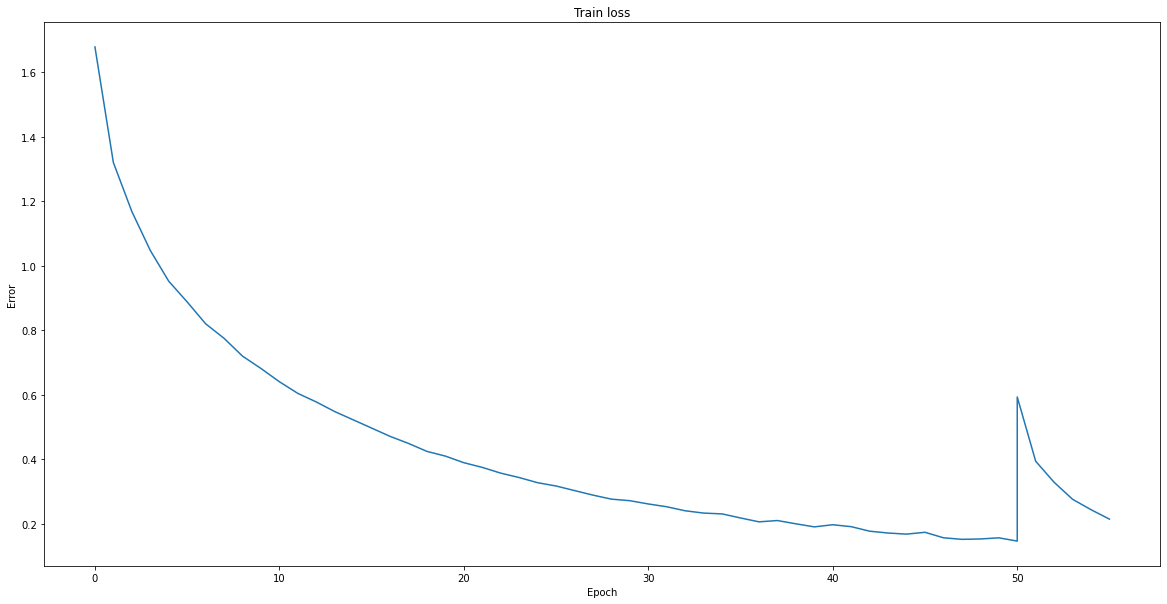

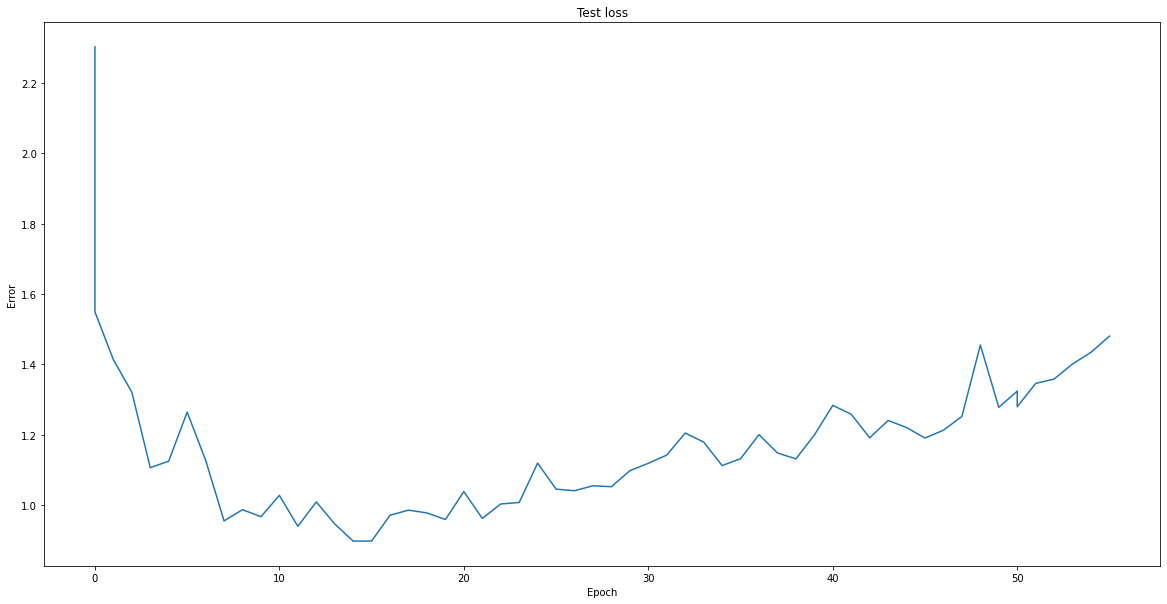

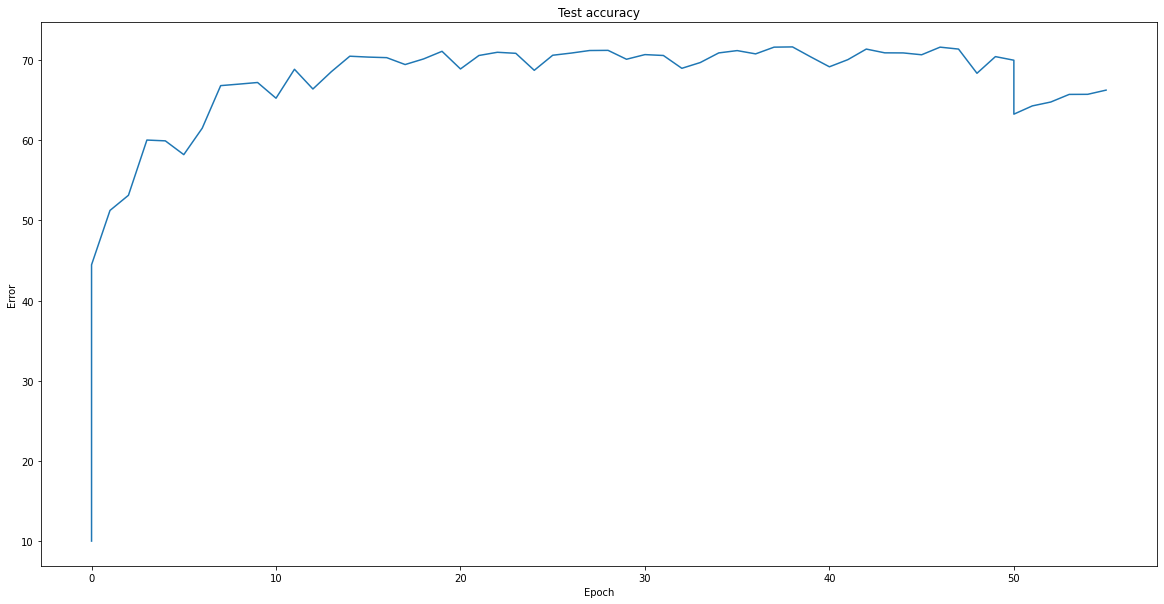

In [53]:
from torch.utils.data import Dataset
class AugmentedDataset(Dataset):

    def __init__(self, og_dataset, perturbations, batchsize, device):
        self.og_dataset = og_dataset
        self.perturbations = perturbations
        self.bs = batchsize
        self.device = device

    def __len__(self):
        return len(self.og_dataset) * 2

    def __getitem__(self, index):
        if index < len(self.og_dataset):
          return self.og_dataset[index]
        else:
          nindex = index % (len(self.og_dataset)-1)
          #return (self.og_dataset[nindex][0].to(self.device) + self.perturbations[nindex//self.bs][nindex%self.bs], self.og_dataset[nindex][1])
          return ((self.og_dataset[nindex][0] + self.perturbations[nindex//self.bs][nindex%self.bs]).detach().clone(), self.og_dataset[nindex][1])

def augment_model_6(data_train, data_test):
  BATCH_SIZE = 100
  TEST_BATCH_SIZE = 10
  EPOCHS = 55
  LEARNING_RATE = 0.01
  MOMENTUM = 0.1
  USE_CUDA = True
  SEED = None
  PRINT_INTERVAL = 250
  WEIGHT_DECAY = 0.0005

  EXPERIMENT_VERSION = 'CifarNet6' + '_1' # increment this to start a new experiment
  LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'
  
  # Now the actual training code
  use_cuda = USE_CUDA and torch.cuda.is_available()
  if SEED is not None:
      torch.manual_seed(SEED)

  device = torch.device("cuda" if use_cuda else "cpu")
  print('Using device', device)
  import multiprocessing
  print('num cpus:', multiprocessing.cpu_count())

  kwargs = {'num_workers': multiprocessing.cpu_count(),
            'pin_memory': True} if use_cuda else {}

  class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  
  train_p = torch.load('ee_CifarNet6_train_perturbations.pt')
  test_p = torch.load('ee_CifarNet6_test_perturbations.pt')
  #train_p = [t.to(device) for t in torch.load('ee_CifarNet6_train_perturbations.pt')]
  #test_p = [t.to(device) for t in torch.load('ee_CifarNet6_test_perturbations.pt')]
  ndata_train = AugmentedDataset(data_train, train_p, 100, device)
  ndata_test = AugmentedDataset(data_test, test_p, 100, device)
  train_loader = torch.utils.data.DataLoader(ndata_train, batch_size=BATCH_SIZE,
                                              shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(ndata_test, batch_size=BATCH_SIZE,
                                              shuffle=False, **kwargs)
  
  model = CifarNet6().to(device)
  optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  start_epoch = model.load_last_model(LOG_PATH)

  train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))

  try:
      for epoch in range(start_epoch, EPOCHS + 1):
          train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
          test_loss, test_accuracy = test(model, device, test_loader)
          train_losses.append((epoch, train_loss))
          test_losses.append((epoch, test_loss))
          test_accuracies.append((epoch, test_accuracy))
          pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
          model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
  except KeyboardInterrupt as ke:
      print('Interrupted')
  except:
      import traceback
      traceback.print_exc()
  finally:
      model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
      ep, val = zip(*train_losses)
      pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
      ep, val = zip(*test_losses)
      pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
      ep, val = zip(*test_accuracies)
      pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

augment_model_6(data_train, data_test)

In [28]:
print('perturbing CifarNet1')
perturb_cifar_class(CifarNet1, data_train, data_test)
print('perturbing CifarNet2')
perturb_cifar_class(CifarNet2, data_train, data_test)
print('perturbing CifarNet4')
perturb_cifar_class(CifarNet4, data_train, data_test)
print('perturbing CifarNet5')
perturb_cifar_class(CifarNet5, data_train, data_test)
print('perturbing CifarNet6')
perturb_cifar_class(CifarNet6, data_train, data_test)

perturbing CifarNet1
Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([4, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([4]) = 0MB
conv2.weight -> 	torch.Size([4, 4, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([4]) = 0MB
conv3.weight -> 	torch.Size([8, 4, 3, 3]) = 0MB
conv3.bias -> 	torch.Size([8]) = 0MB
conv4.weight -> 	torch.Size([8, 8, 3, 3]) = 0MB
conv4.bias -> 	torch.Size([8]) = 0MB
conv5.weight -> 	torch.Size([16, 8, 3, 3]) = 0MB
conv5.bias -> 	torch.Size([16]) = 0MB
conv6.weight -> 	torch.Size([16, 16, 3, 3]) = 0MB
conv6.bias -> 	torch.Size([16]) = 0MB
fc1.weight -> 	torch.Size([1000, 16384]) = 65MB
fc1.bias -> 	torch.Size([1000]) = 0MB
fc2.weight -> 	torch.Size([500, 1000]) = 2MB
fc2.bias -> 	torch.Size([500]) = 0MB
fc3.weight -> 	torch.Size([10, 500]) = 0MB
fc3.bias -> 	torch.Size([10]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/Classes/CSE 455/ghabt/cifar/logs/CifarNet1_1/050.pt
<class '__main__.CifarNet1'>
0 10000 20000 30000 40000 
e

KeyboardInterrupt: ignored

# misc testing

In [ ]:
print(len(data_train))

50000


In [ ]:
pert = torch.zeros(3, 32, 32)
pert.requires_grad = True
model.zero_grad()
output = model(torch.unsqueeze(data_train[0][0] + pert, 0))
loss = F.cross_entropy(output, torch.LongTensor([6]))
print(pert.grad)
loss.backward()
print(pert.grad)
pert.grad.zero_()
output = model(torch.unsqueeze(data_train[0][0] + pert, 0))
loss = F.cross_entropy(output, torch.LongTensor([6]))
loss.backward()
print(pert.grad)

None
tensor([[[-9.4933e-06, -1.1765e-05, -4.9469e-06,  ...,  2.6746e-06,
           1.5488e-05,  8.8471e-06],
         [-7.2817e-06,  3.6126e-07, -2.4281e-06,  ..., -2.7893e-05,
           9.3975e-06,  2.2082e-05],
         [ 1.0326e-05,  1.5087e-05,  6.7551e-06,  ..., -1.2397e-06,
           5.6559e-06, -6.8191e-07],
         ...,
         [ 1.0700e-05,  5.3748e-06, -1.1876e-05,  ..., -1.4346e-05,
           4.8758e-06, -3.6357e-06],
         [ 1.9428e-06,  8.0270e-07,  1.4181e-05,  ..., -2.5710e-06,
           6.8924e-06, -8.4269e-06],
         [-1.9022e-06, -2.8686e-06,  1.7896e-05,  ...,  6.2952e-06,
          -4.0104e-06, -9.5089e-06]],

        [[ 6.6750e-06, -1.9776e-07, -1.3227e-06,  ...,  9.1177e-06,
          -1.7135e-05, -1.6153e-05],
         [-7.3656e-08, -2.5094e-06, -8.2880e-06,  ..., -3.6544e-06,
           2.8749e-06, -2.3862e-06],
         [-8.6125e-06,  3.3306e-06, -2.2128e-05,  ..., -1.1655e-05,
          -8.2633e-06, -1.1806e-05],
         ...,
         [-4.2999e-0

In [ ]:
model = CifarNet1()
print(str(type(data_train[0][1])))
print(data_train[0][0].shape)
output = model(torch.unsqueeze(data_train[0][0], 0))
tlabel = torch.LongTensor([3])
print(output.shape, tlabel.shape)
print(str(type(output)))
print(output.shape)
print(torch.LongTensor([3]).shape)
print(str(type(torch.LongTensor([3]))))
print(output.size(0))
print(torch.LongTensor([3]).size(0))
loss = F.cross_entropy(output, tlabel)
print(loss)

<class 'int'>
torch.Size([3, 32, 32])
torch.Size([1, 10]) torch.Size([1])
<class 'torch.Tensor'>
torch.Size([1, 10])
torch.Size([1])
<class 'torch.Tensor'>
1
1
tensor(2.2797, grad_fn=<NllLossBackward>)


In [ ]:
hm_loader = torch.utils.data.DataLoader(data_train, batch_size=1, shuffle=True)
for batch_idx, (data, label) in enumerate(hm_loader):
  print(data.shape)
  #print(data)
  print(str(type(data)))
  print(label)
  print(str(type(label)))
  print(batch_idx)
  output = model(data)
  print(output)
  print(output.shape)
  print(label.shape)
  loss = model.loss(output, label)
  break

torch.Size([2, 3, 32, 32])
<class 'torch.Tensor'>
tensor([4, 0])
<class 'torch.Tensor'>
0
tensor([[-0.0308, -0.0489,  0.0380, -0.0141,  0.0063,  0.0450,  0.0163,  0.0421,
         -0.0087, -0.0438],
        [-0.0308, -0.0489,  0.0380, -0.0141,  0.0063,  0.0450,  0.0164,  0.0421,
         -0.0087, -0.0438]], grad_fn=<AddmmBackward>)
torch.Size([2, 10])
torch.Size([2])


In [ ]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                            shuffle=True, **kwargs)
print(len(data_test))

10000
